# Feature Neutralization

One unique thing about the stock market is that the relationship between features and returns is "non-stationary". Features that have strong predictive power during some time periods may not have any in other time periods or may even hurt performance. 

"Feature risk" is a measure of this uncertainty, "feature exposure" is a way to measure our model's exposure to this risk, and "feature neutralization" is a way for us to control this exposure.

In this notebook, we will learn how to quantify feature risk, measure our model's feature exposure, and apply feature neutralization to improve the performance of our model. 

In [33]:
# Install dependencies
!pip install -q numerapi pandas matplotlib lightgbm pyarrow cloudpickle

# Inline plots
%matplotlib inline

## 1. Feature Risk

In order to quantify feature risk, let us evaluate the performance of each feature on their own. Since there is no model to train, we can do this analysis on the training dataset.

In [34]:
from numerapi import NumerAPI
import json
import pandas as pd

# Download data
napi = NumerAPI()
napi.download_dataset("v4.1/train.parquet");
napi.download_dataset("v4.1/features.json");

# Load data
feature_metadata = json.load(open("v4.1/features.json")) 
feature_cols = feature_metadata["feature_sets"]["small"]
training_data = pd.read_parquet("v4.1/train.parquet", columns=["era"] + feature_cols + ["target"])

2023-07-27 10:00:51,276 INFO numerapi.utils: target file already exists
2023-07-27 10:00:51,279 INFO numerapi.utils: download complete
2023-07-27 10:00:51,862 INFO numerapi.utils: target file already exists
2023-07-27 10:00:51,863 INFO numerapi.utils: download complete


In [35]:
from scipy import stats
import numpy as np

# Numerai's primary scoring metric
def numerai_corr(preds, target):
    # rank (keeping ties) then gaussianize predictions to standardize prediction distributions
    ranked_preds = (preds.rank(method="average").values - 0.5) / preds.count()
    gauss_ranked_preds = stats.norm.ppf(ranked_preds)
    # center targets around 0
    centered_target = target - target.mean()
    # raise both preds and target to the power of 1.5 to accentuate the tails
    preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5
    target_p15 = np.sign(centered_target) * np.abs(centered_target) ** 1.5
    # finally return the Pearson correlation
    return np.corrcoef(preds_p15, target_p15)[0, 1]

In [36]:
# Compute the per-era correlation of each feature to the target
per_era_corrs = pd.DataFrame(index=training_data.era.unique())
for feature_name in feature_cols:
    per_era_corrs[feature_name] = training_data.groupby("era").apply(lambda d: numerai_corr(d[feature_name], d["target"]))

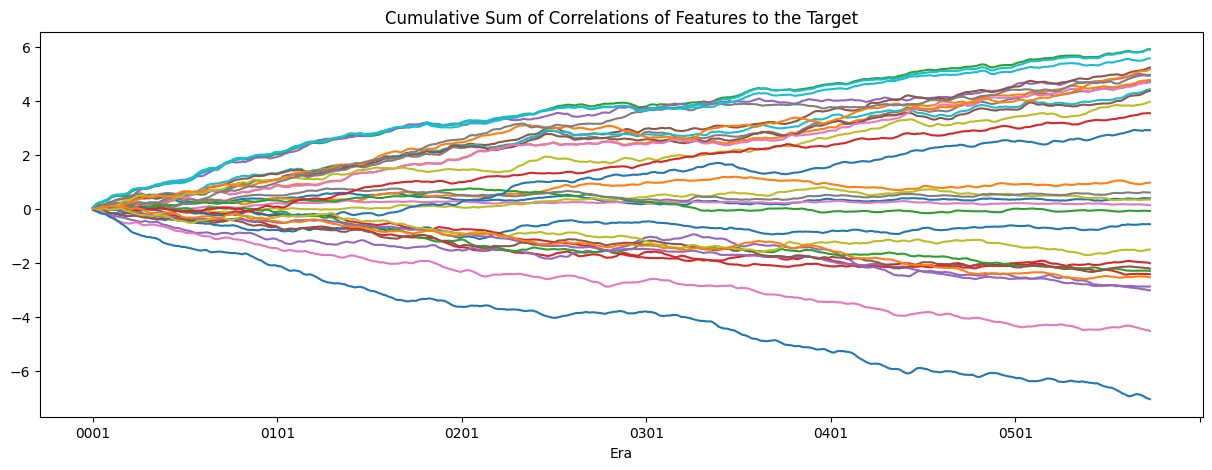

In [37]:
# Plot the cumulative sum of the per-era correlations of the features
per_era_corrs.cumsum().plot(figsize=(15, 5), title="Cumulative Sum of Correlations of Features to the Target", legend=False, xlabel="Era");

Features with consistent negative correlations are just as good as ones with positive correlations since the sign of each feature is arbitrary. Before further analysis, we should flip the sign of correlations for the features with negative average correlations.

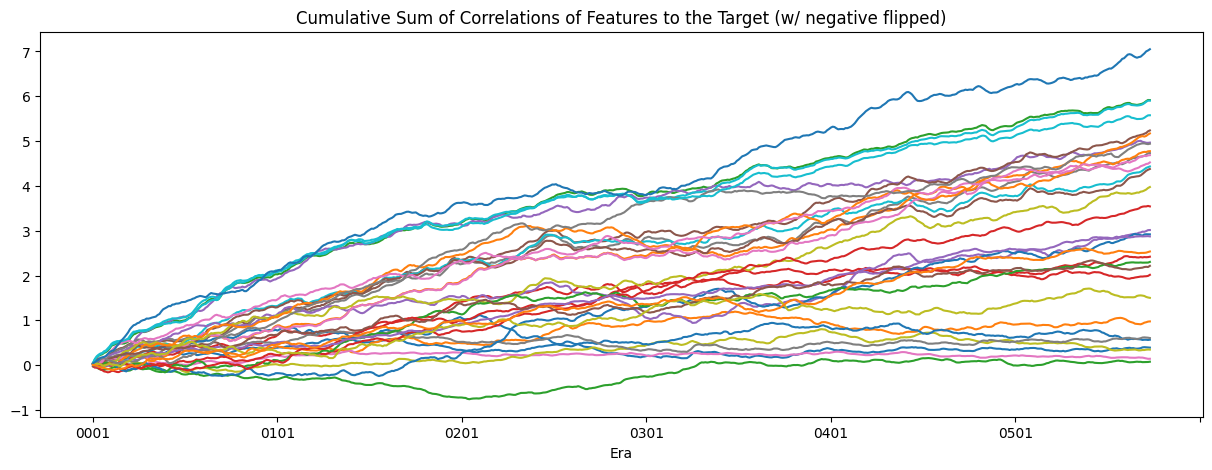

In [38]:
# Flip the sign of correlations for the features with negative average correlations
per_era_corrs *= np.sign(per_era_corrs.mean())
per_era_corrs.cumsum().plot(figsize=(15, 5), title="Cumulative Sum of Correlations of Features to the Target (w/ negative flipped)", legend=False, xlabel="Era");

Let's compute some summary performance metrics as we did in the previous notebook for our model predictions.

- `mean` mean of per era correlations
- `std` standard deviation of per era correlations
- `sharpe` standard deviation adjusted mean of per era correlations
- `max_drawdown` maximum peak to trough drop in cumulative per era correlation 
- `delta` the absolute delta between the first and second half of eras

In [39]:
def metrics(per_era_corr):
    corr_mean = per_era_corr.mean()
    corr_std = per_era_corr.std(ddof=0)
    corr_sharpe = corr_mean / corr_std
    max_drawdown = -(per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

    eras = training_data.era.unique()
    corr_mean_first_half = per_era_corr.loc[eras[:len(eras)//2]].mean()
    corr_mean_second_half = per_era_corr.loc[eras[len(eras)//2:]].mean()
    delta = abs(corr_mean_first_half - corr_mean_second_half)

    return { "mean": corr_mean, "std": corr_std, "sharpe": corr_sharpe, "max_drawdown": max_drawdown, "delta": delta }

# compute performance metrics for each feature
feature_metrics = pd.DataFrame(index=feature_cols, columns=["mean", "std", "sharpe", "max_drawdown", "delta"])
for feature_name in feature_cols:
    feature_metrics.loc[feature_name] = metrics(per_era_corrs[feature_name])

# make all cells numeric 
feature_metrics = feature_metrics.apply(pd.to_numeric)

feature_metrics.sort_values("mean", ascending=False)

,mean,std,sharpe,max_drawdown,delta
feature_unswaddled_inenarrable_goody,0.012282,0.019340,0.635063,-0.252688,0.001813
feature_coraciiform_sciurine_reef,0.010305,0.015693,0.656670,-0.164262,0.006789
feature_piping_geotactic_cusp,0.010284,0.015753,0.652796,-0.179569,0.005983
feature_unsizable_ancestral_collocutor,0.009715,0.015981,0.607901,-0.204947,0.007183
feature_distressed_bloated_disquietude,0.009124,0.018104,0.503994,-0.268530,0.001863
feature_sodding_choosy_eruption,0.009009,0.018243,0.493818,-0.515897,0.002571
feature_cyclopedic_maestoso_daguerreotypist,0.008652,0.018057,0.479125,-0.187818,0.008906
feature_unpainted_censual_pinacoid,0.008607,0.016073,0.535502,-0.208227,0.006267
feature_fribble_gusseted_stickjaw,0.008319,0.016708,0.497914,-0.200807,0.000165
feature_elaborate_intimate_bor,0.008247,0.018632,0.442644,-0.306579,0.002554


Looking at these summary visualizations below, the most obvious observation is that `mean` and `sharpe` seem strongly correlated. This should not be suprising given that `sharpe` is just `mean` divided by `std`.

A more interesting obvservation is that `mean` does not seem to be strongly correlated with `std`, `max_drawdown`, or `delta`. This tells us very clearly that just because a feature has high `mean` does not mean that it is consistent.

To better understand feature risk, let us examine `std`, `max_drawdown`, and `delta` more closely.


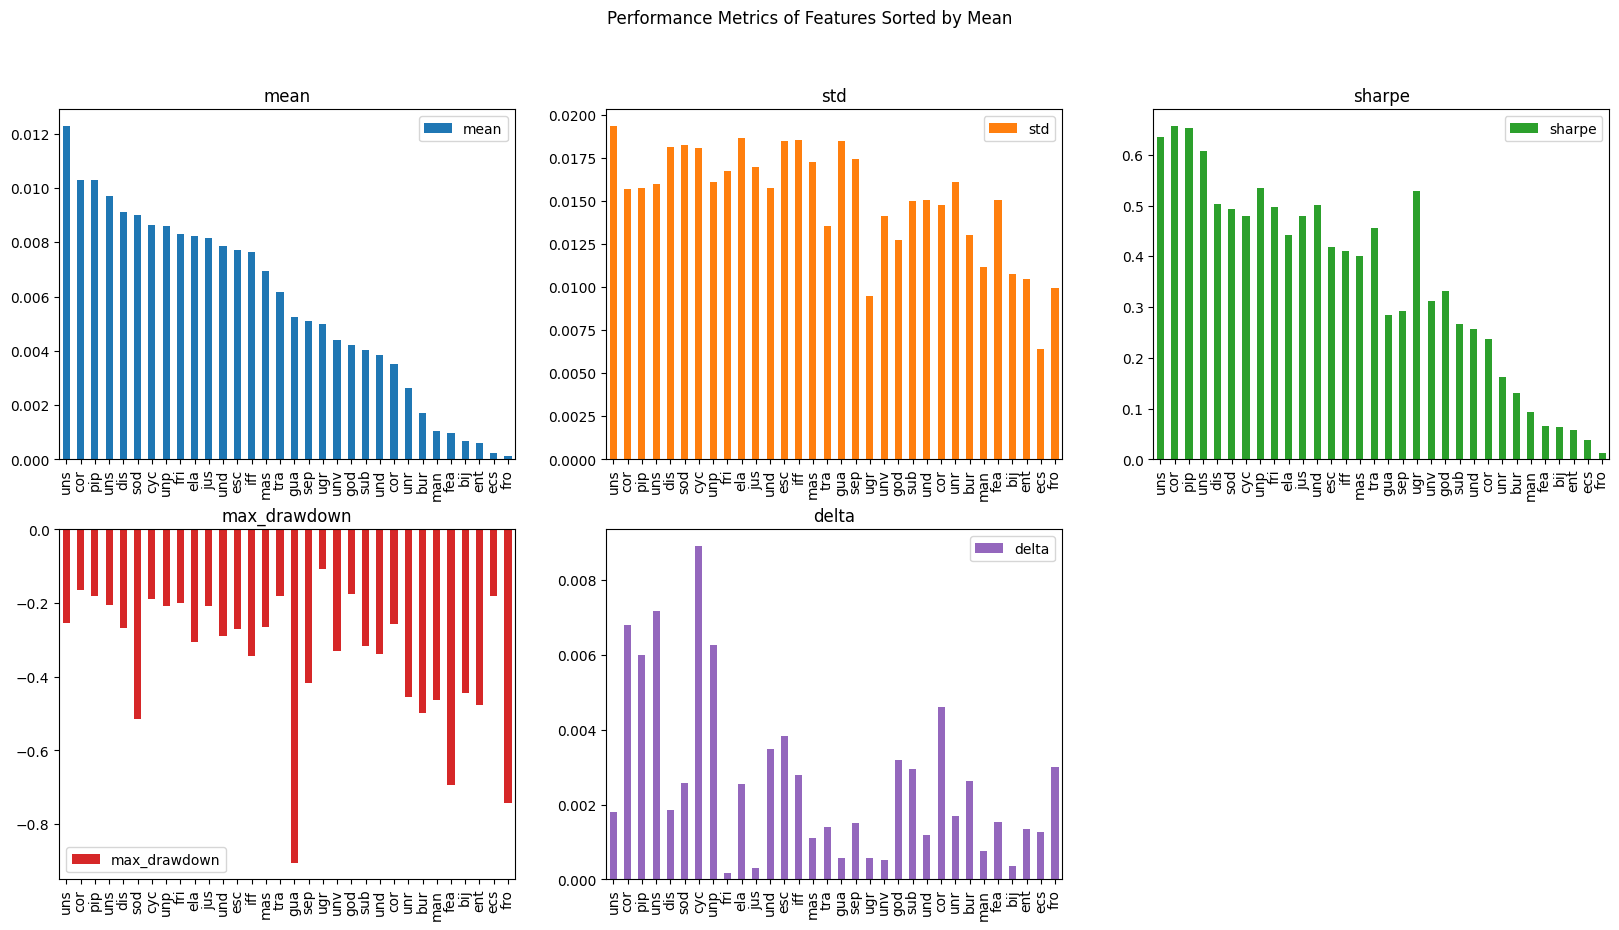

In [40]:
# make a copy of the feature metrics 
feature_metrics_copy = feature_metrics.copy()

# shorten the feature names by removing the prefix and taking the first 3 characters
feature_metrics_copy.index = feature_metrics_copy.index.str.replace("feature_", "")
feature_metrics_copy.index = feature_metrics_copy.index.str[:3]

# plot the performance metrics of the features as bar charts sorted by mean
feature_metrics_copy.sort_values("mean", ascending=False).plot.bar(
    subplots=True, figsize=(20, 10), layout=(2, 3), sharex=False, title="Performance Metrics of Features Sorted by Mean"
);

Below is a comparison of the highest and lowest `std` features. Which one looks more risky to you and why?

One might argue that the orange line looks more risky given the sudden and violent reversals. Extrapolating forward, we may expect this volatility to continue out of sample.

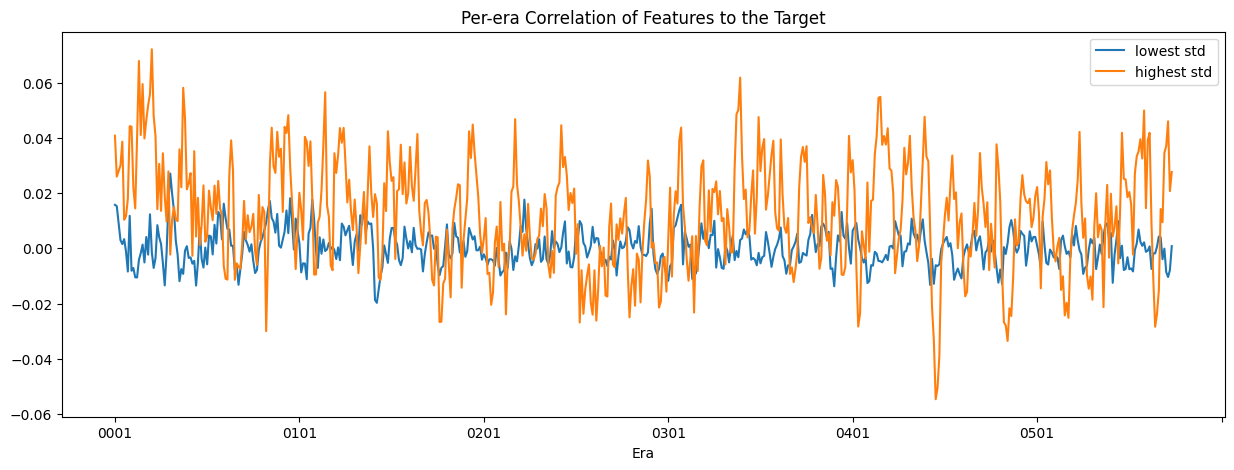

In [41]:
import matplotlib.pyplot as plt

# plot the per era correlation of the feature with the highest vs lowest std
per_era_corrs[[feature_metrics["std"].idxmin(), feature_metrics["std"].idxmax()]].plot(
    figsize=(15, 5), title="Per-era Correlation of Features to the Target", xlabel="Era"
) 
plt.legend(["lowest std", "highest std"]);

Below is a comparison of the highest and lowest `delta` features. Which one looks more risky to you and why?

One might argue that the orange line looks more risky given the big difference in performance between the first and second half, despite having a higher cumsum. Extraoploating forward, we may expect this feature to stop working completely or even start going negative out of sample. 

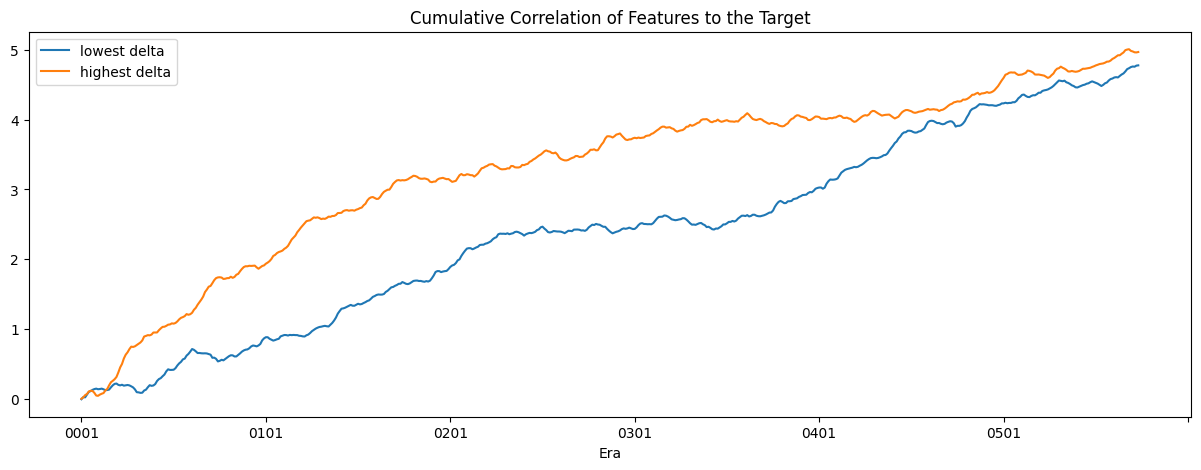

In [42]:
# plot the per era correlation of the feature with the highest vs lowest delta
per_era_corrs[[feature_metrics["delta"].idxmin(), feature_metrics["delta"].idxmax()]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Era"
) 
plt.legend(["lowest delta", "highest delta"]);

Below is a comparison of the highest and lowest `max_drawdown` features. Which one looks more risky to you and why?

One might argue that the orange line is more risky given the huge drawdown in the middle despite having a higher cumsum. Extrapolating forward, we may expect it to have another big drawdown out of sample.

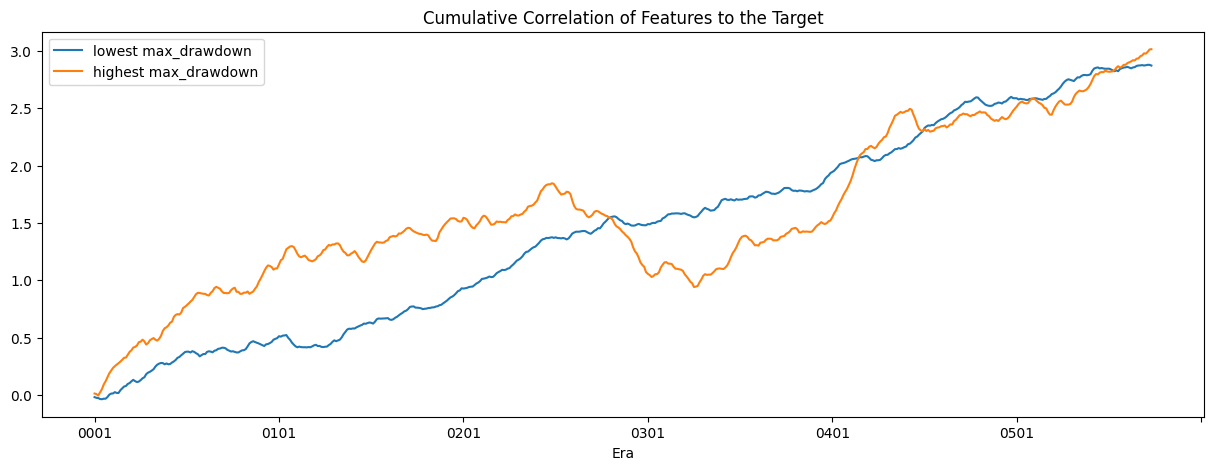

In [43]:
# plot the per era correlation of the feature with the highest vs lowest max_drawdown
per_era_corrs[[feature_metrics["max_drawdown"].idxmax(), feature_metrics["max_drawdown"].idxmin()]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Era"
)
plt.legend(["lowest max_drawdown", "highest max_drawdown"]);

The metrics analyzed above are only a few of many different ways you can quantify feature risk. What are some other ways you can think of? 

# 2. Feature Exposure 

`Feature exposure` is a measure of a model's exposure to the risk of individual features, given by the Pearson correlation between a model's predictions and each feature. 

Let's train a model, make some predictions on the validation set, and measure its feature exposure.

In [44]:
import lightgbm as lgb

try: 
  model = lgb.Booster(model_file='small_lgb.model');
except lgb.basic.LightGBMError:
  model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    num_leaves=2 ** 5,
    colsample_bytree=0.1
  )
  model.fit(
    training_data[feature_cols],
    training_data["target"]
  );
  model.booster_.save_model("small_lgb.model");

In [45]:
# Download validation data 
napi.download_dataset("v4.1/validation.parquet");

# Load the validation data but only the "small" subset of features
validation_data = pd.read_parquet("v4.1/validation.parquet", columns=["era", "data_type"] + feature_cols + ["target"]) 

# Filter for data_type == "validation"
validation_data = validation_data[validation_data["data_type"] == "validation"]
del validation_data["data_type"]

# Generate predictions against the out of sample validation features
validation_data["prediction"] = model.predict(validation_data[feature_cols])

2023-07-27 10:03:27,600 INFO numerapi.utils: target file already exists
2023-07-27 10:03:27,601 INFO numerapi.utils: download complete


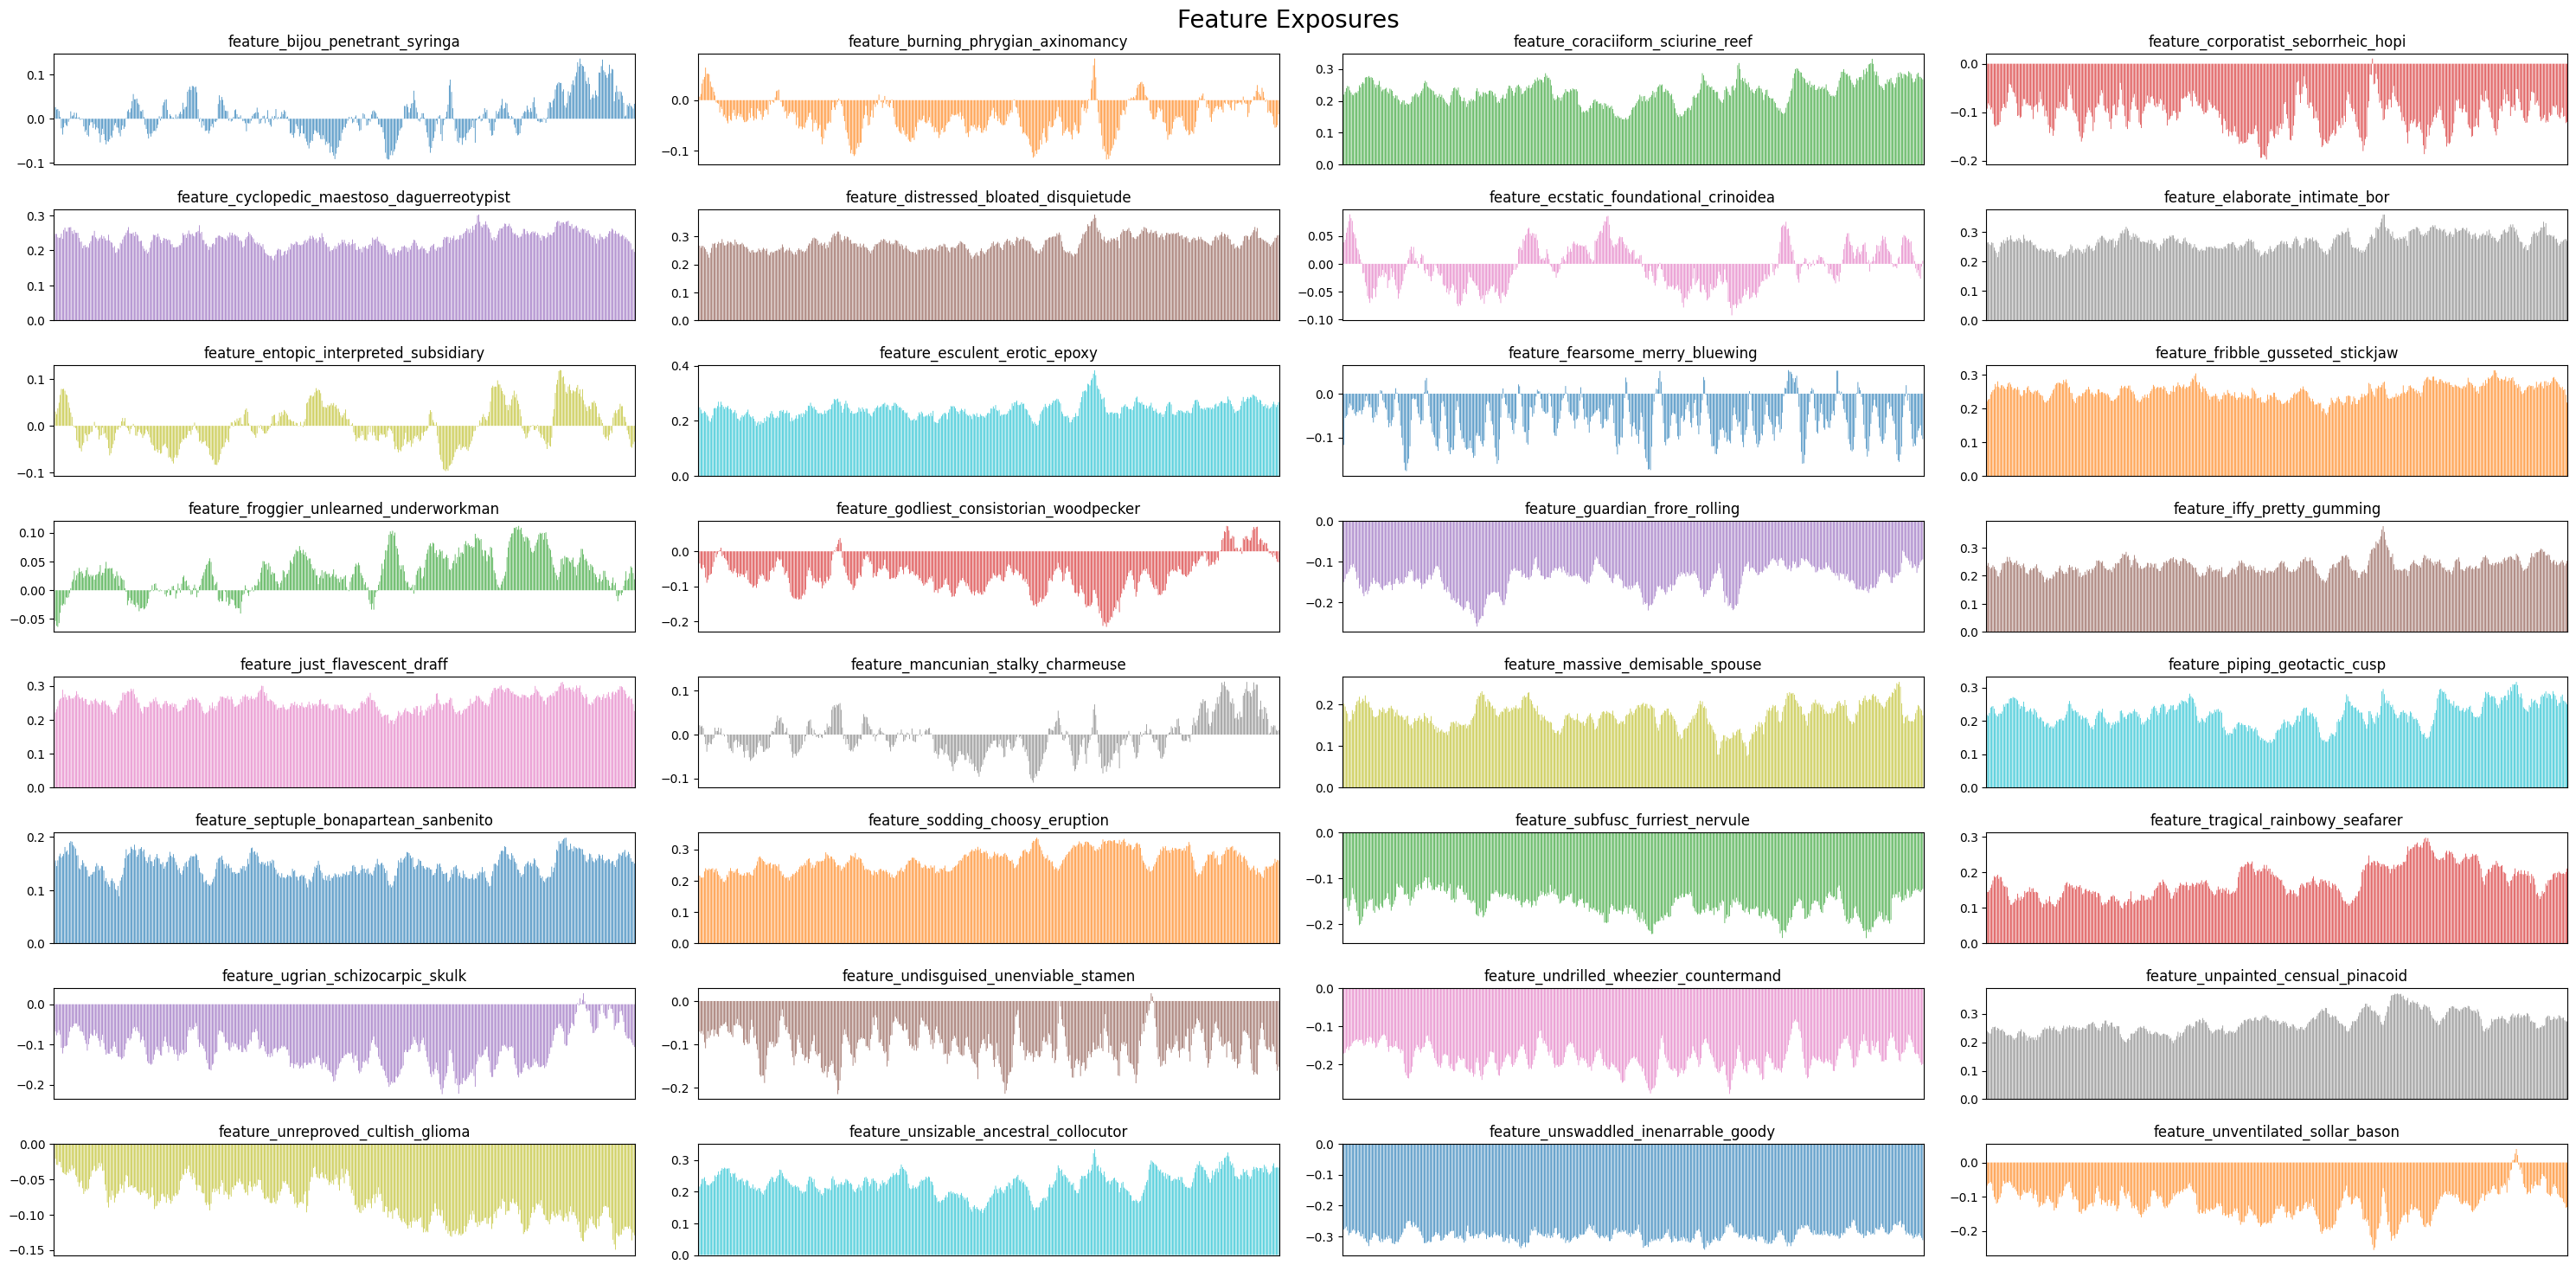

In [46]:
# compute the (regular) Peason correlation of the predictions with each feature
feature_exposures = validation_data.groupby("era").apply(lambda d: d[feature_cols].corrwith(d["prediction"]))

# plot the feature exposures as bar charts 
feature_exposures.plot.bar(
    subplots=True, figsize=(30, 15), layout=(8, 4), sharex=False, title="Feature Exposures", xticks=[], legend=False, snap=False
);
for ax in plt.gcf().axes:
    ax.set_xlabel("")
plt.tight_layout(pad=1.5)
plt.gcf().suptitle("Feature Exposures", fontsize=20);

Our model seems to be consistently correlated to some features. If these features suddenly reverse or stop working out of sample, then our model predictions are at risk of exhibiting the same risky characteristics we saw above. 

Another, perhaps more useful way to visualize the overall feature exposure of our model is to look at the per-era max feature exposure across all features. This is a simple way for us to estimate the maximum feature risk we are exposed to across all features at the same time.

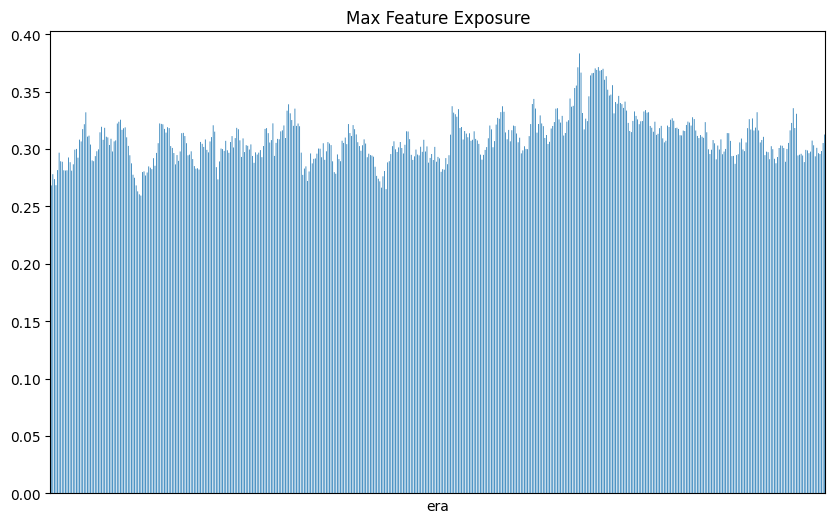

In [47]:
# Plot the max feature exposure per era
max_feature_expposure_per_era = validation_data.groupby("era").apply(lambda d: d[feature_cols].corrwith(d["prediction"]).abs().max())
max_feature_expposure_per_era.plot(title="Max Feature Exposure", kind="bar", figsize=(10, 6), xticks=[], snap=False);

In [48]:
# Mean max feature exposure across eras
max_feature_exposure_mean = max_feature_expposure_per_era.mean()
max_feature_exposure_mean

0.30844633563421664

## 3. Feature Neutralization

`Feature Neutralization` is a way to reduce `Feature Exposure`. 

At a high level, you can think of feature neutralization as just removing the component of your predictions that are linearly correlated with features, leaving only the residual non-linear component.   

Let's try to neutralize our predictions and see how that affects the performance of our model.

In [49]:
# Neutralize predictions to features
def neutralize(predictions: pd.DataFrame, features: pd.DataFrame, proportion: float = 1.0) -> pd.DataFrame:
    # add a constant term the features so we can fit the bias/offset term
    features = np.hstack((features, np.array([np.mean(predictions)] * len(features)).reshape(-1, 1)))
    # remove the component of the predictions that are linearly correlated with features
    return predictions - proportion * features @ (np.linalg.pinv(features, rcond=1e-6) @ predictions)

In [50]:
# Neutralize predictions per-era againat all features at different proportions
proportions = [0.25, 0.5, 0.75, 1.0]
for proportion in proportions:
    neutralized = validation_data.groupby("era").apply(lambda d: neutralize(d["prediction"], d[feature_cols], proportion=proportion))
    validation_data[f"neutralized_{proportion*100:.0f}"] = neutralized.reset_index().set_index("id")["prediction"] 

# Align the neutralized predictions with the validation data
prediction_cols = ["prediction"] + [f for f in validation_data.columns if "neutralized" in f]
validation_data[["era"] + prediction_cols + ["target"]]

,era,prediction,neutralized_25,neutralized_50,neutralized_75,neutralized_100,target
id,,,,,,,
n000101811a8a843,0575,0.488841,0.364025,0.239208,0.114391,-0.010426,0.750000
n001e1318d5072ac,0575,0.495411,0.370351,0.245291,0.120230,-0.004830,0.000000
n002a9c5ab785cbb,0575,0.502395,0.380195,0.257994,0.135793,0.013592,0.500000
n002ccf6d0e8c5ad,0575,0.507658,0.382413,0.257167,0.131922,0.006676,0.000000
n0051ab821295c29,0575,0.486678,0.364377,0.242076,0.119776,-0.002525,0.500000
...,...,...,...,...,...,...,...
nffd5c02c7a57ee7,1067,0.489917,0.367746,0.245576,0.123405,0.001234,0.250000
nffddfb386ab0c50,1067,0.475346,0.354267,0.233187,0.112108,-0.008971,0.500000
nffe908e0138f7bc,1067,0.507613,0.380230,0.252847,0.125464,-0.001919,0.500000


In the chart below, we can see that we are able to progressively reduce our max feature exposure all the way down to 0 with a nuetralization porportion = 100%.   

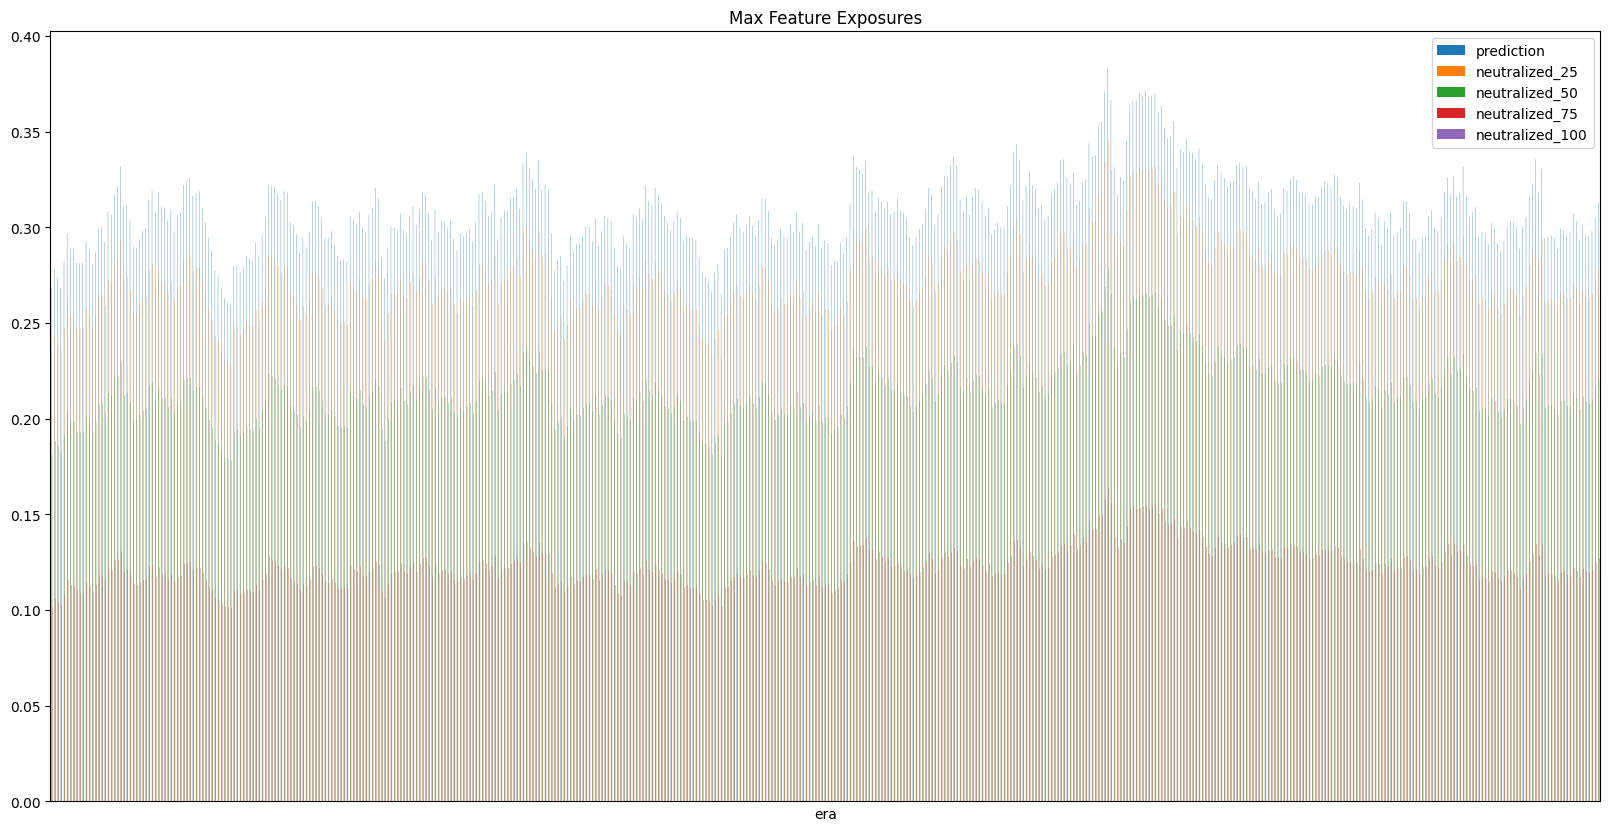

In [51]:
# Compute max feature exposure for each set of predictions
max_feature_exposures = {}
for col in prediction_cols:
    max_feature_exposures[col] = validation_data.groupby("era").apply(lambda d: d[feature_cols].corrwith(d[col]).abs().max())
max_feature_exposures = pd.DataFrame(max_feature_exposures)

# plot 
max_feature_exposures.plot.bar(figsize=(20, 10), title="Max Feature Exposures", xticks=[], snap=False);

Looking at the cumulative correlation chart below, we see that the overall performance of our model increases with some neutralization at 25% and 50% porportion, but starts hurting performance at higher levels of 75% and 100%.

This result hints at the inherent tradeoff between risk and reward in finance, where reducing risk too much can often hurt performance. This also makes sense here, since we know that features themselves can sometime be very predictive on their own, so reducing our exposure to features means that we are also reducing at least some of the predictive power of our predictions.

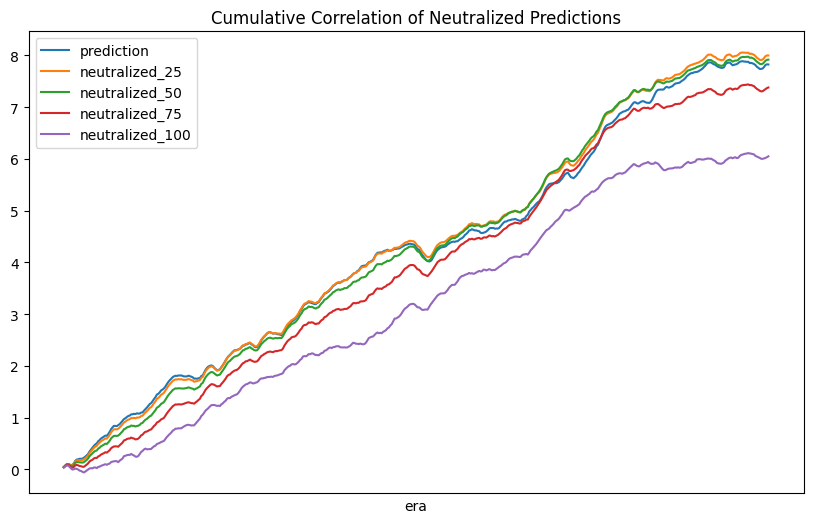

In [52]:
# Plot cumulative correlations
correlations = {}
cumulative_correlations = {}
for col in prediction_cols:
    correlations[col] = validation_data.groupby("era").apply(lambda d: numerai_corr(d[col], d["target"]))
    cumulative_correlations[col] = correlations[col].cumsum() 

pd.DataFrame(cumulative_correlations).plot(title="Cumulative Correlation of Neutralized Predictions", figsize=(10, 6), xticks=[]);

Looking at the summary performance metrics below, we can make some further observations
- `max_feature_exposure_mean` goes down as we increase neutralization, as expected
- `std` and `max_drawdown` also go down as we increase neutralization, which supports our theory that feature neutralization can improve consistency 
- `sharpe` increases with 25% of neutralization but starts decreasing at 50% and beyond

Based on this simple analysis, it seems like neutralizing at 50% strikes a good balance between performance and consistency. What do you think?

In your research, you may want to experiment with neutralizing different features at different porportions and make your own judgement on how to balance the risk reward benefits of neutralization. You may even consider incorporating neutralization into the objective function of your training. If you want to learn more about the math behind the neutralization function, we highly encourage you to read up on the following posts: 
- https://forum.numer.ai/t/model-diagnostics-feature-exposure/899
- https://forum.numer.ai/t/an-introduction-to-feature-neutralization-exposure/4955

In [53]:
summary_metrics = {}
for col in prediction_cols:
    mean = correlations[col].mean()
    std = correlations[col].std()
    sharpe = mean / std
    rolling_max = cumulative_correlations[col].expanding(min_periods=1).max()
    max_drawdown = (rolling_max - cumulative_correlations[col]).max()
    max_feature_exposure_mean = max_feature_exposures[col].mean()
    summary_metrics[col] = {
        "mean": mean,
        "std": std,
        "sharpe": sharpe,
        "max_drawdown": max_drawdown,
        "max_feature_exposure_mean": max_feature_exposure_mean
    }
pd.set_option('display.float_format', lambda x: '%f' % x)
pd.DataFrame(summary_metrics).T

,mean,std,sharpe,max_drawdown,max_feature_exposure_mean
prediction,0.015869,0.021357,0.743044,0.342537,0.308446
neutralized_25,0.016223,0.020702,0.783654,0.314493,0.273282
neutralized_50,0.016060,0.019708,0.814878,0.282033,0.215141
neutralized_75,0.014967,0.018438,0.811766,0.213556,0.123164
neutralized_100,0.012269,0.017486,0.701657,0.159665,0.000000


To wrap up this notebook, let's pickle and upload our improved model with 50% neutralization.

In [54]:
def predict_neutral(live_features: pd.DataFrame) -> pd.DataFrame:
    predictions = pd.Series(model.predict(live_features[feature_cols]), index=live_features.index) 
    # neutralize to features by 50%
    neutralized = neutralize(predictions, live_features[feature_cols], 0.5)
    submission = pd.Series(neutralized).rank(pct=True, method="first")
    return submission.to_frame("prediction")

In [55]:
# Quick test
current_round_number = napi.get_current_round()
napi.download_dataset("v4.1/live.parquet", f"v4.1/live_{current_round_number}.parquet")
live_features = pd.read_parquet(f"v4.1/live_{current_round_number}.parquet", columns=feature_cols)
predict_neutral(live_features)

2023-07-27 10:13:29,177 INFO numerapi.utils: target file already exists
2023-07-27 10:13:29,178 INFO numerapi.utils: download complete


,prediction
id,
n001c8fa54b1d611,0.382573
n001f0b161cc90fc,0.087335
n00275a82a0739bd,0.719554
n00314637402fd75,0.491793
n003afe9ec01bdd4,0.549139
...,...
nffa71f514e451d4,0.982776
nffd0955c3c413a9,0.667680
nffd760be1277881,0.939007


In [56]:
# Use the cloudpickle library to serialize your function and its dependencies
import cloudpickle
p = cloudpickle.dumps(predict_neutral)
with open("predict_neutral.pkl", "wb") as f:
    f.write(p)

In [57]:
# Download file if running in Google Colab
try:
    from google.colab import files
    files.download('predict_neutral.pkl')
except:
    pass

That's it! Now head back to [numer.ai](numer.ai) to upload your model!